<a href="https://colab.research.google.com/github/tsutsumi-ozro/tweet_analysis/blob/main/Tweet_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import data

読み込み方法が悪いからか、ところどころツイートが抜けている気がしますが、厳密な分析をするわけではないので一旦スルーします。

In [6]:
import os
# カレントディレクトリ設定
# GoogleColabで動かしているので、データはGoogleDriveにある想定
os.chdir('/content/drive/MyDrive/Twitter_Analysis/')

In [7]:
with open('data/tweets.js') as f:
    data = f.read()

In [8]:
# 参考：　https://oku.edu.mie-u.ac.jp/~okumura/python/tweetdata.html

import json
from dateutil.parser import parse
from pytz import timezone

tw = json.loads(data[data.find('['):])

text_list = []
for t in tw:
    full_text = t['tweet']['full_text']
    created_at = t['tweet']['created_at']
    text_list.append(full_text)

In [9]:
print(f'tweet数: {len(text_list)}')
print(f'直近のツイート5件: \n {text_list[:5]}')

tweet数: 8907
直近のツイート5件: 
 ['RT @johannyjm1: AI作曲のコンテストを開催します🙌🙌\nチェックしてくれ！！！！！🥳🥳🥳🥳🥳🥳', '足元ヒーターが機能してない寒さ', 'Twitterのデータ全然届かないな', '暖房入れても室温上がらん\n興奮してきた', 'さむい']


見てみると、RTも含まれていることがわかる.<br>
RT情報は必要ないので、一旦元データを眺めてどのような前処理をするか考える.

In [11]:
with open('output/original_data.txt', mode='w') as f:
    f.write('\n'.join(text_list))

見てみると<br>
* * *
<img width="294" alt="image" src="https://user-images.githubusercontent.com/69502527/215440558-79d8c60a-b2c2-4407-997c-302e685ea547.png"><br>
* * *
のように表示されるRTと<br>
* * *
<img width="209" alt="image" src="https://user-images.githubusercontent.com/69502527/215440803-387fce28-d414-4cc4-b334-c6d7bf42c6b0.png"><br>
* * *
のように表示されるリプライがあります。<br>
そのほかにも引用リプライやurl、画像を挿入した時に出てくる<br>
* * *
<img width="329" alt="image" src="https://user-images.githubusercontent.com/69502527/215441977-9bbdbd40-6867-42bf-b4a5-c294b3e4649f.png"><br>
* * *
のような*https*から始まるような文字列も不要なので削除します。<br>
＠から始まるリプライは個性が出ると捉えられるので残そうか迷いましたが、一旦消します。

## Preprocessing

In [39]:
import re
import unicodedata
def preprocess_tweet(text):
    #改行されることによって一部が前処理されない状態になるのを防ぐ
    text = text.replace('\n', '')
    text = re.sub('@.+', '', text)
    text = re.sub('http.+', '', text)
    text = re.sub('RT.+', '', text)
    #日本語は半角全角が混合しているので整理
    #参考：https://tex2e.github.io/blog/python/unicodedata-normalize
    text = unicodedata.normalize('NFKC', text)

    return text

preprocecced_text = [preprocess_tweet(tweet) for tweet in text_list]
preprocecced_text = [tweet for tweet in preprocecced_text if tweet != '']
preprocecced_text[:5]

['足元ヒーターが機能してない寒さ',
 'Twitterのデータ全然届かないな',
 '暖房入れても室温上がらん興奮してきた',
 'さむい',
 '風速見てジム行くのやめようとしてる']

これも一旦テキストファイルとして保存します。

In [40]:
with open('output/preprocecced.txt', mode='w') as f:
    f.write('\n'.join(preprocecced_text))

## 形態素解析

今回はTweetなので文分割を行いませんが、行う場合は[pysdb](https://aclanthology.org/2020.nlposs-1.15.pdf)がオススメです。<br>
今回はWordCloudなど色々使って可視化したい、ということで単語に分割します。<br>
~~うまく使えるわけではないですが~~<br>[Sudachi](https://github.com/WorksApplications/Sudachi)のPython版[`SudachiPy`](https://github.com/WorksApplications/SudachiPy) という形態素解析ツールを使用します。

In [ ]:
%pip install sudachipy sudachidict_core

In [42]:
from sudachipy import tokenizer
from sudachipy import dictionary

tokenizer_obj = dictionary.Dictionary().create()

- Sudachiにおいて、単語分割の分割基準は以下の3種類があります。
    - A: 短単位
    - B: 中間
    - C: 固有表現相当<br>


Aが一番細かくて、Cが一番大雑把という感じです。<br>
正直どれが一番いいかわからないので、それっぽい文章で全部試してみます。

In [48]:
preprocecced_text[:10]

['足元ヒーターが機能してない寒さ',
 'Twitterのデータ全然届かないな',
 '暖房入れても室温上がらん興奮してきた',
 'さむい',
 '風速見てジム行くのやめようとしてる',
 '1つのことが片付かない限り他のことが出来ない性格辞めたいな',
 '最近死んどるな',
 'ゲームより睡眠の方が気持ちいい場合、死 ',
 'カッフェ行く予定だったけど雨なので中止',
 '【悲報】この時間に黒子のバスケ、決勝突入。夜更かし不可避']

In [52]:
mode_a = tokenizer.Tokenizer.SplitMode.A
mode_b = tokenizer.Tokenizer.SplitMode.B
mode_c = tokenizer.Tokenizer.SplitMode.C

test_tweet = preprocecced_text[9] # 【悲報】この時間に黒子のバスケ、決勝突入。夜更かし不可避
result_a = [m.surface() for m in tokenizer_obj.tokenize(test_tweet, mode_a)]
result_b = [m.surface() for m in tokenizer_obj.tokenize(test_tweet, mode_b)]
result_c = [m.surface() for m in tokenizer_obj.tokenize(test_tweet, mode_c)]

print(f'result mode A: {result_a}')
print(f'result mode B: {result_b}')
print(f'result mode C: {result_c}')

result mode A: ['【', '悲報', '】', 'この', '時間', 'に', '黒子', 'の', 'バスケ', '、', '決勝', '突入', '。', '夜更かし', '不可避']
result mode B: ['【', '悲報', '】', 'この', '時間', 'に', '黒子', 'の', 'バスケ', '、', '決勝', '突入', '。', '夜更かし', '不可避']
result mode C: ['【', '悲報', '】', 'この', '時間', 'に', '黒子', 'の', 'バスケ', '、', '決勝', '突入', '。', '夜更かし', '不可避']


えー、まさかの完全一致.<br>
他の文章でも試したましたが、A, B, Cどれも一致しました。<br>
異なる例は以下のようになります。Cで十分って感じですのでCで行います。
```
# 複数粒度分割

mode = tokenizer.Tokenizer.SplitMode.C
[m.surface() for m in tokenizer_obj.tokenize("国家公務員", mode)]
# => ['国家公務員']

mode = tokenizer.Tokenizer.SplitMode.B
[m.surface() for m in tokenizer_obj.tokenize("国家公務員", mode)]
# => ['国家', '公務員']

mode = tokenizer.Tokenizer.SplitMode.A
[m.surface() for m in tokenizer_obj.tokenize("国家公務員", mode)]
# => ['国家', '公務', '員']
```

In [53]:
splited_text = []
for tweet in preprocecced_text:
    result = [m.surface() for m in tokenizer_obj.tokenize(tweet, mode_c)]
    splited_text.append(result)

In [54]:
splited_text[0]

['足元', 'ヒーター', 'が', '機能', 'し', 'て', 'ない', '寒', 'さ']

試しに単語を数えてみる.

In [55]:
from collections import defaultdict
word_dict = defaultdict(int)
for para in splited_text:
    for word in para:
        word_dict[word] += 1
#上位10位を表示
print(sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[:10])
#下位10位を表示
print(sorted(word_dict.items(), key=lambda x: x[1])[:10])

[('の', 3264), ('て', 2385), (' ', 2101), ('に', 1912), ('で', 1844), ('た', 1733), ('が', 1469), ('か', 1141), ('し', 1116), ('、', 1105)]
[('足元', 1), ('ヒーター', 1), ('室温', 1), ('さむい', 1), ('片付か', 1), ('カッフェ', 1), ('MoT', 1), ('コネヒト', 1), ('Kanmu', 1), ('語る', 1)]


## WordCloud

In [56]:
# 日本語フォントをダウンロード
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 27 not upgraded.
Need to get 8,251 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-ipafont-gothic all 00303-18ubuntu1 [3,526 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-ipafont-mincho all 00303-18ubuntu1 [4,725 kB]
Fetched 8,251 kB in 1s (8,110 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 129499 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-18ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-18ubuntu1) ...
Selecting previously unselected package fonts-ipaf

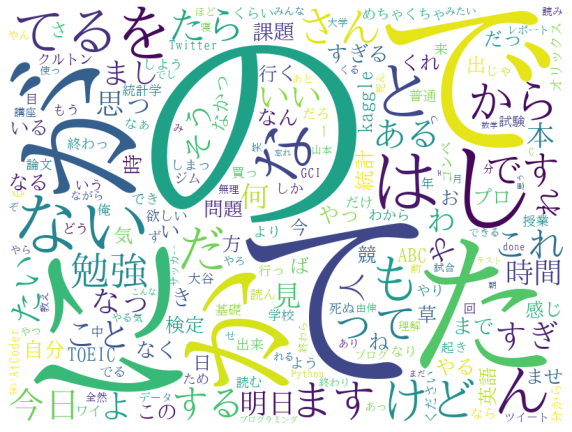

In [72]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import random

def create_word_cloud(word_seq):
    res = WordCloud(
        font_path = '/usr/share/fonts/truetype/fonts-japanese-mincho.ttf', 
        width=800, height=600, background_color='white', 
        #regexp=r"[\w']+"
    ).generate(word_seq)
    plt.figure(figsize=(10, 8))
    plt.imshow(res)
    plt.axis('off')
    plt.show()

text = []
for para in splited_text:
    text += para
random.shuffle(text)
text = ' '.join(text)

create_word_cloud(text)

「の」とか「が」とか機能語ばかりで全然面白くないですね。<br>
WordCloudの引数としてstopwordsがあり、リストとして表示して欲しくない単語を渡すと表示せずに出力してくれます。<br>
ただ、今回は品詞解析などを行い、これらを改善したいと思います。

In [83]:
# 単語と品詞のタプルをリストに格納

word_pos = []
for para in preprocecced_text:
    for m in tokenizer_obj.tokenize(para, mode_c):
        word_pos.append(
            (m.surface(), m.part_of_speech()[0])
        )
print(preprocecced_text[0])
print(word_pos[:9])

足元ヒーターが機能してない寒さ
[('足元', '名詞'), ('ヒーター', '名詞'), ('が', '助詞'), ('機能', '名詞'), ('し', '動詞'), ('て', '助動詞'), ('ない', '助動詞'), ('寒', '形容詞'), ('さ', '接尾辞')]


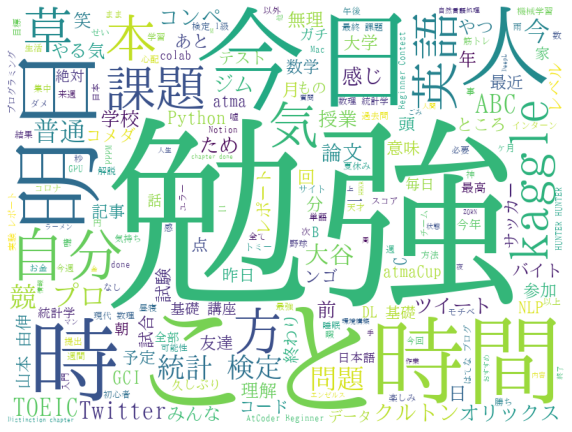

In [73]:
#名詞のみをwordcloudで可視化
nouns = []
for (word, pos) in word_pos:
    if pos=='名詞':
        nouns.append(word)
create_word_cloud(' '.join(nouns))

## GiNZAを用いて固有表現を抽出

日本語解析ライブラリの`GiNZA`を用いて解析を行い、固有表現を抽出します。<br>
[ホームページ](https://megagonlabs.github.io/ginza/)<br>
[論文](https://www.jstage.jst.go.jp/article/jnlp/27/3/27_695/_pdf)

In [74]:
%pip install -U ginza ja_ginza_electra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 KB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.8 MB/s eta 0:00:00
  Created wheel for sudachitra: filename=SudachiTra-0.1.7-py3-none-any.whl size=266095 sha256=07f622d0fbac758e90ff62f8885b614830bc60c0adccea7cdb0f9e06f20799b1
  Stored in directory: /root/.cache/pip/wheels/97/ad/02/69094014ac4631f81c227d7cf059fd46c11df9e5bfd03c6f41
Successfully built sudachitra
  Atte

In [76]:
import spacy
from ginza import *

nlp = spacy.load('ja_ginza_electra')

In [79]:
# from https://ja.wikipedia.org/wiki/Twitter_(%E4%BC%81%E6%A5%AD)
text = 'Twitter, Inc.は、カリフォルニア州サンフランシスコを拠点とする、アメリカ合衆国のIT企業である。'
doc = nlp(text)
spacy.displacy.render(doc, style='ent', jupyter=True) #entity->固有表現

In [81]:
# 30分かかる
ent_dict = defaultdict(int)

for doc in nlp.pipe(preprocecced_text):
    for ent in doc.ents:
        ent_dict[ent.text] += 1
print(sorted(ent_dict.items(), key=lambda t: t[1], reverse=True)[:10])

[('さん', 333), ('英語', 100), ('kaggle', 89), ('TOEIC', 87), ('ABC', 77), ('クルトン', 76), ('オリックス', 75), ('大谷', 68), ('GCI', 61), ('Twitter', 48)]


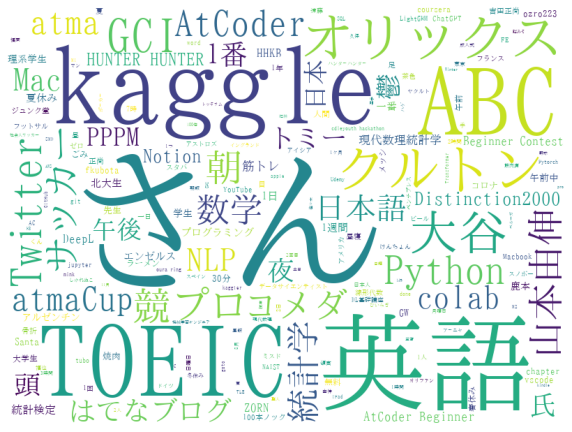

In [82]:
ents = []
for ent_text, count in ent_dict.items():
  ents += [ent_text] * count
random.shuffle(ents)

create_word_cloud(' '.join(ents))